In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-07T17:46:28.743784+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl
#import tqdm

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
import lightgbm as lgb

from itertools import product

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
#from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

#print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

sklearn_version: 0.24.2


In [6]:
%watermark --iversions

lightgbm: 3.3.2
numpy   : 1.20.3
pandas  : 0.25.3



## Reproducibility block

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [8]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [9]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'))#, index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [10]:
df_train.shape, df_test.shape, len(cat_cols), len(num_cols), #x_train.shape, x_val.shape,

((6987, 1235), (3000, 1231), 0, 1198)

отделяем метки от данных

In [11]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

y_val = x_val[['views', 'depth', 'full_reads_percent']]
x_val.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

In [12]:
#cat_cols + num_cols

In [13]:
cat_cols = cat_cols + ['category']

In [14]:
df_train['category'] = df_train['category'].astype('category')
x_train['category']  = x_train['category'].astype('category')
x_val['category']    = x_val['category'].astype('category')
df_test['category']  = df_test['category'].astype('category')

In [33]:
#for el in num_cols:
#    print(el)

In [16]:
def train_lgb_cat(inp_df, inp_vals, inp_category, inp_cat_cols, inp_num_cols):

    
    num_of_leaves_vars    = [4, 8, 16, 32, 64, 128]
    max_depth_vars        = [4, 8, 16, 32]#, 64, 128]
    min_data_in_leaf_vars = [4, 8, 16, 32]#, 64, 128]
    learn_rate_vars       = [0.1, 0.05, 0.01] #1, 0.5, 
    
    min_rmse = 1000000
    ret_progress = []
    
    for nl, lr, md, mdlf in tqdm(product(num_of_leaves_vars, learn_rate_vars, max_depth_vars, min_data_in_leaf_vars), 
                                total = len(num_of_leaves_vars)*len(learn_rate_vars)*len(max_depth_vars)*len(min_data_in_leaf_vars)
                                ):
    
        params = {
            'task': 'train', 
            'boosting': 'gbdt',
            'objective': 'regression',
            'num_leaves': nl,
            'learning_rate': lr,
            'max_depth': md,
            'min_data_in_leaf': mdlf,
            'metric': {'rmse'},
            #'verbose': -1,
            'random_seed': LGB_RANDOMSEED,
            'force_col_wise': False,
            'n_jobs' : -1,
            
            
            #'reg_alpha': 10,   # != 0  Hard L1 regularization
            #'reg_lambda': 0,   # != 0  Hard L2 regularization
        }


        train_ds_views = lgb.Dataset(inp_df[inp_df.category == inp_category][cat_cols + num_cols],
                                     #inp_df[cat_cols + num_cols],
                                     inp_vals[inp_df.category == inp_category][['views']],
                                     #feature_name = [cat_cols + num_cols]
                                    )

        results = lgb.cv(params, 
                         train_ds_views, 
                         num_boost_round = 10000,
                         nfold = 5,
                         verbose_eval = 500,
                         early_stopping_rounds = 100,
                         stratified = False,
                         #return_cvbooster = True,
                        )

        optimal_rounds = np.argmin(results['rmse-mean'])
        best_cv_score  = min(results['rmse-mean'])

        if best_cv_score < min_rmse:
            ret_progress.append(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')
        
        #print(nl, lr, md, mdlf, optimal_rounds, best_cv_score)
        print(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')  
    
    return ret_progress

In [17]:
#progress = train_lgb_cat(df_train, y_train, '5409f11ce063da9c8b588a12', cat_cols, num_cols)

In [18]:
#with open(os.path.join(DIR_DATA, 'progress.pkl'), 'wb') as pickle_file:
#    pkl.dump(progress, pickle_file)

In [19]:
#lgb_train = lgb.Dataset(x_train, y_train)
#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#views
train_ds_views = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_views = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
#!!!!!!!!!!!!!!!!!!!!!!! #lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


#depth
train_ds_depth = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_depth = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )


#full_reads_percent
train_ds_frp = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_frp = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
#train_ds_frp
#val_ds_frp

## views

In [20]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 6,
    'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [21]:
# fitting the model
lgb_model_views = lgb.train(params,
                            train_set=train_ds_views,
                            valid_sets=val_ds_views,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning

In [22]:
# Get predictions and metrics
preds_train_views = lgb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = lgb_model_views.predict(x_val[cat_cols + num_cols])

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.539100645871381, 0.41703195118988057)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

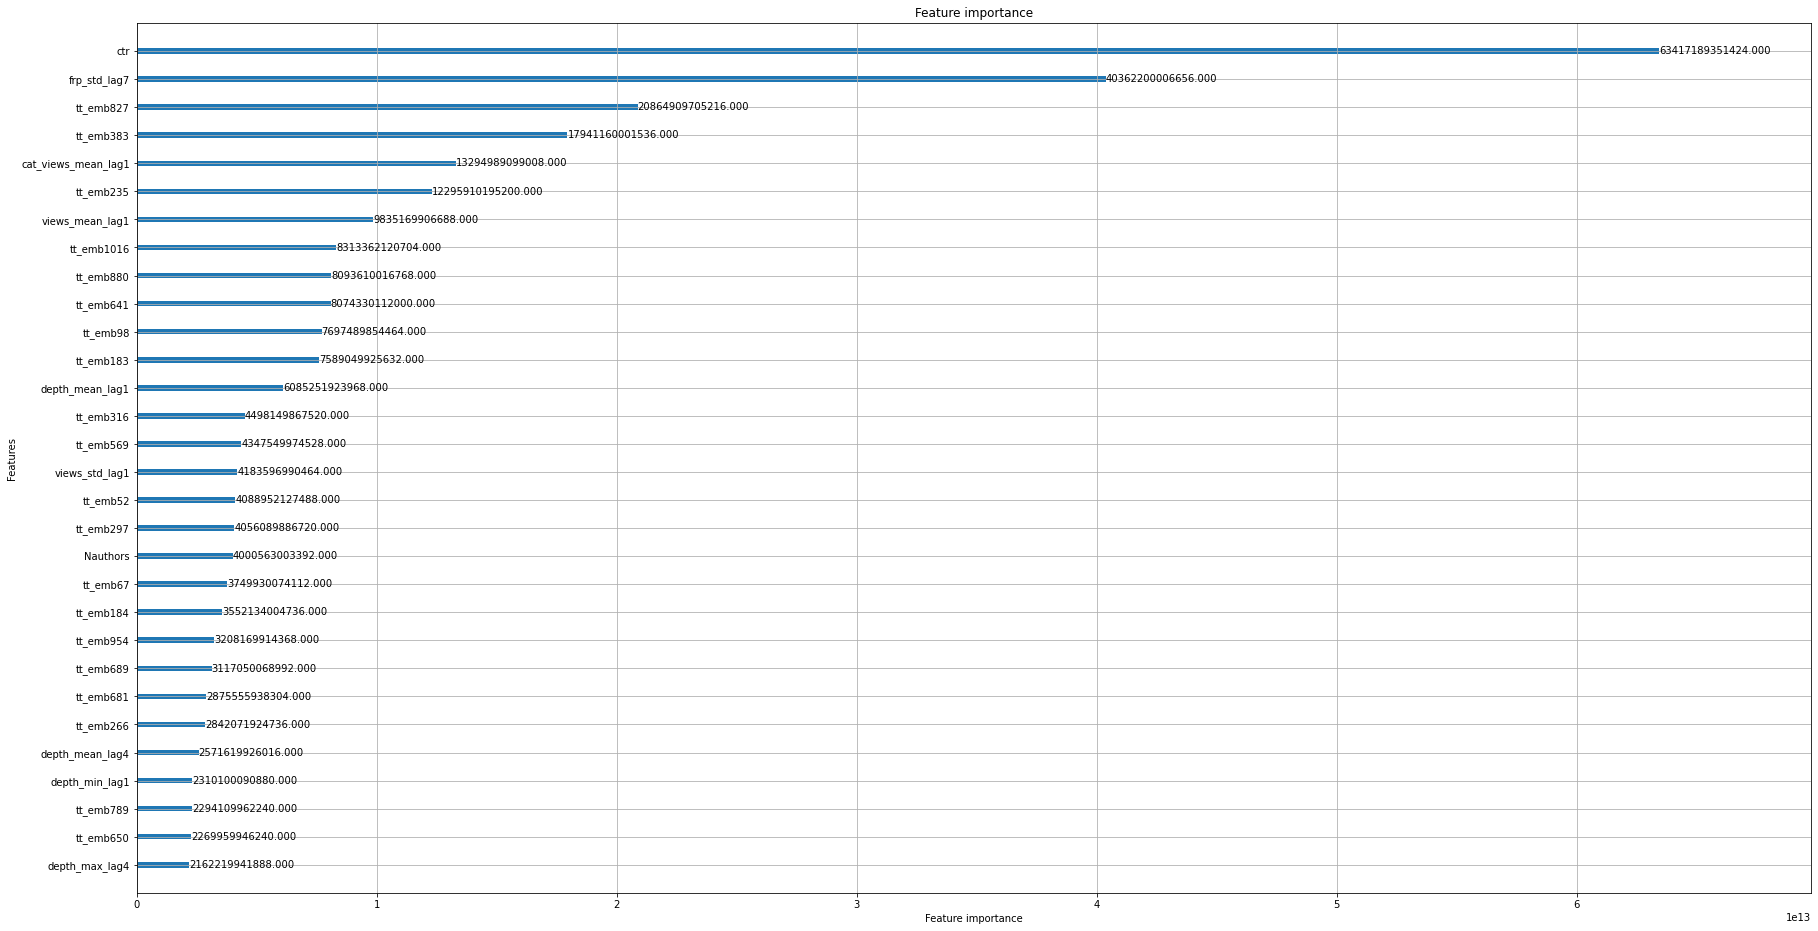

In [23]:
lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'split')
# importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; 
# “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

## depth

In [24]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [25]:
# fitting the model
lgb_model_depth = lgb.train(params,
                            train_set=train_ds_depth,
                            valid_sets=val_ds_depth,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning

In [26]:
# Get predictions and metrics
preds_train_depth = lgb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = lgb_model_depth.predict(x_val[cat_cols + num_cols])

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8875488446680709, 0.7536780439636924)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

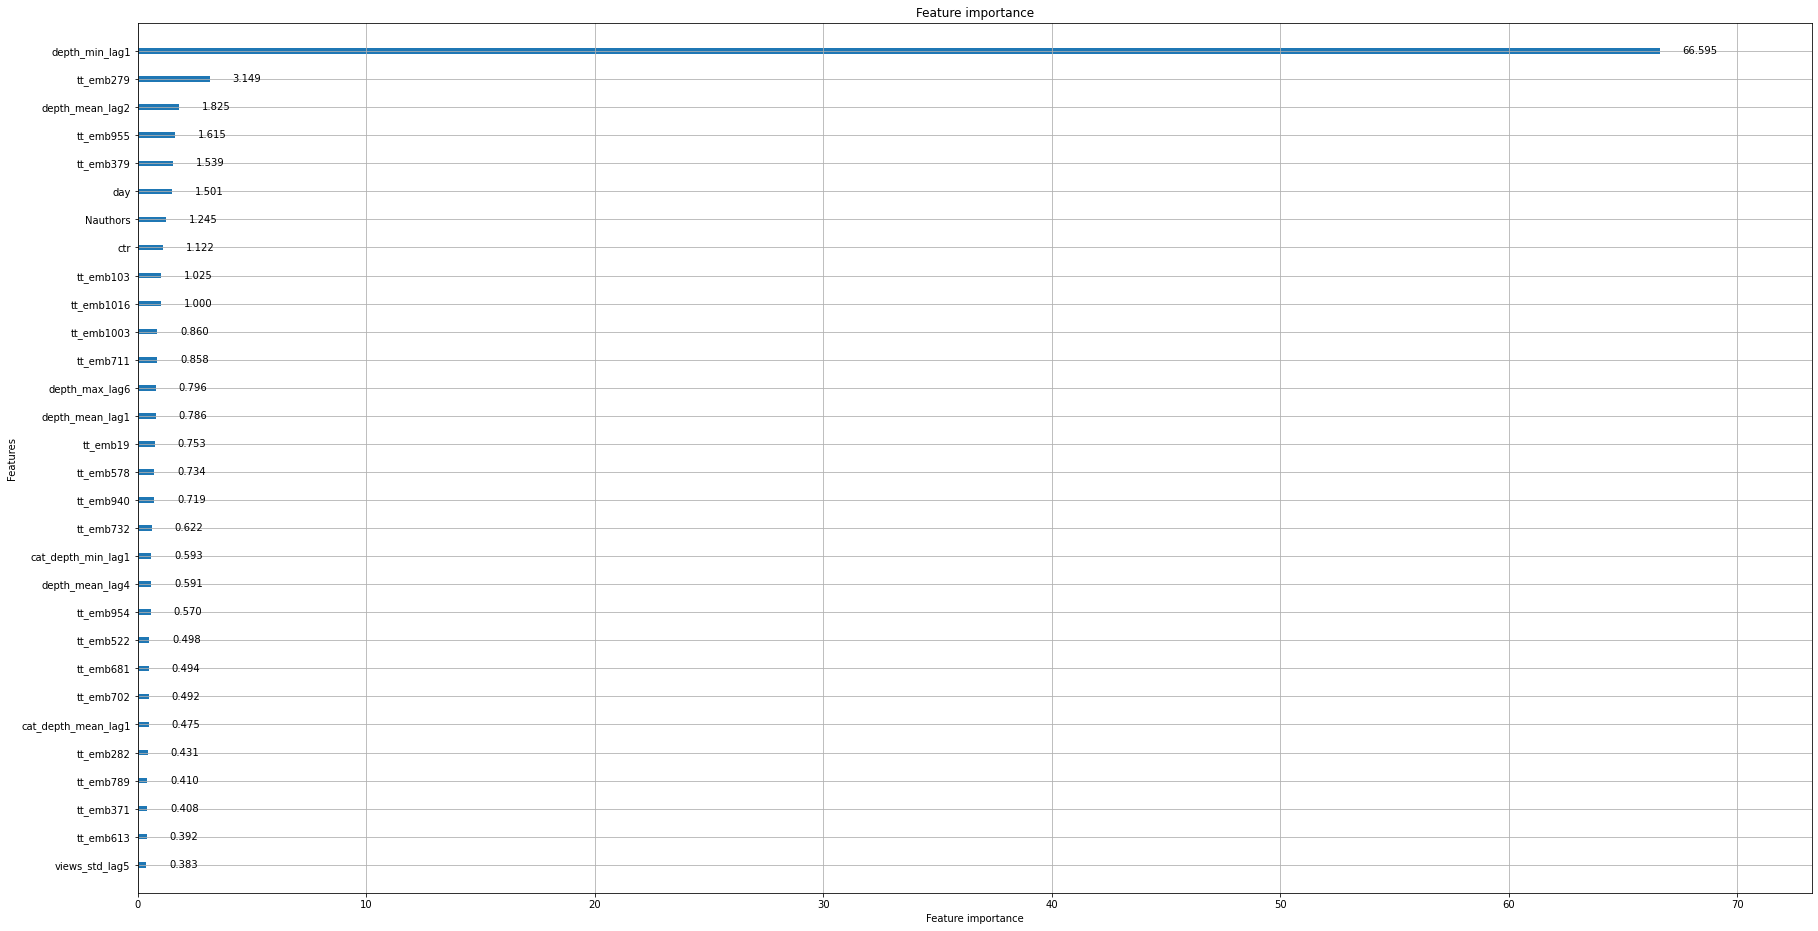

In [27]:
lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

## full_reads_percent

In [28]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [29]:
# fitting the model
lgb_model_frp = lgb.train(params,
                            train_set=train_ds_frp,
                            valid_sets=val_ds_frp,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning

In [30]:
# Get predictions and metrics
preds_train_frp = lgb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp  = lgb_model_frp.predict(x_val[cat_cols + num_cols])

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp  = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.5511975085483092, 0.38191593838301585)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

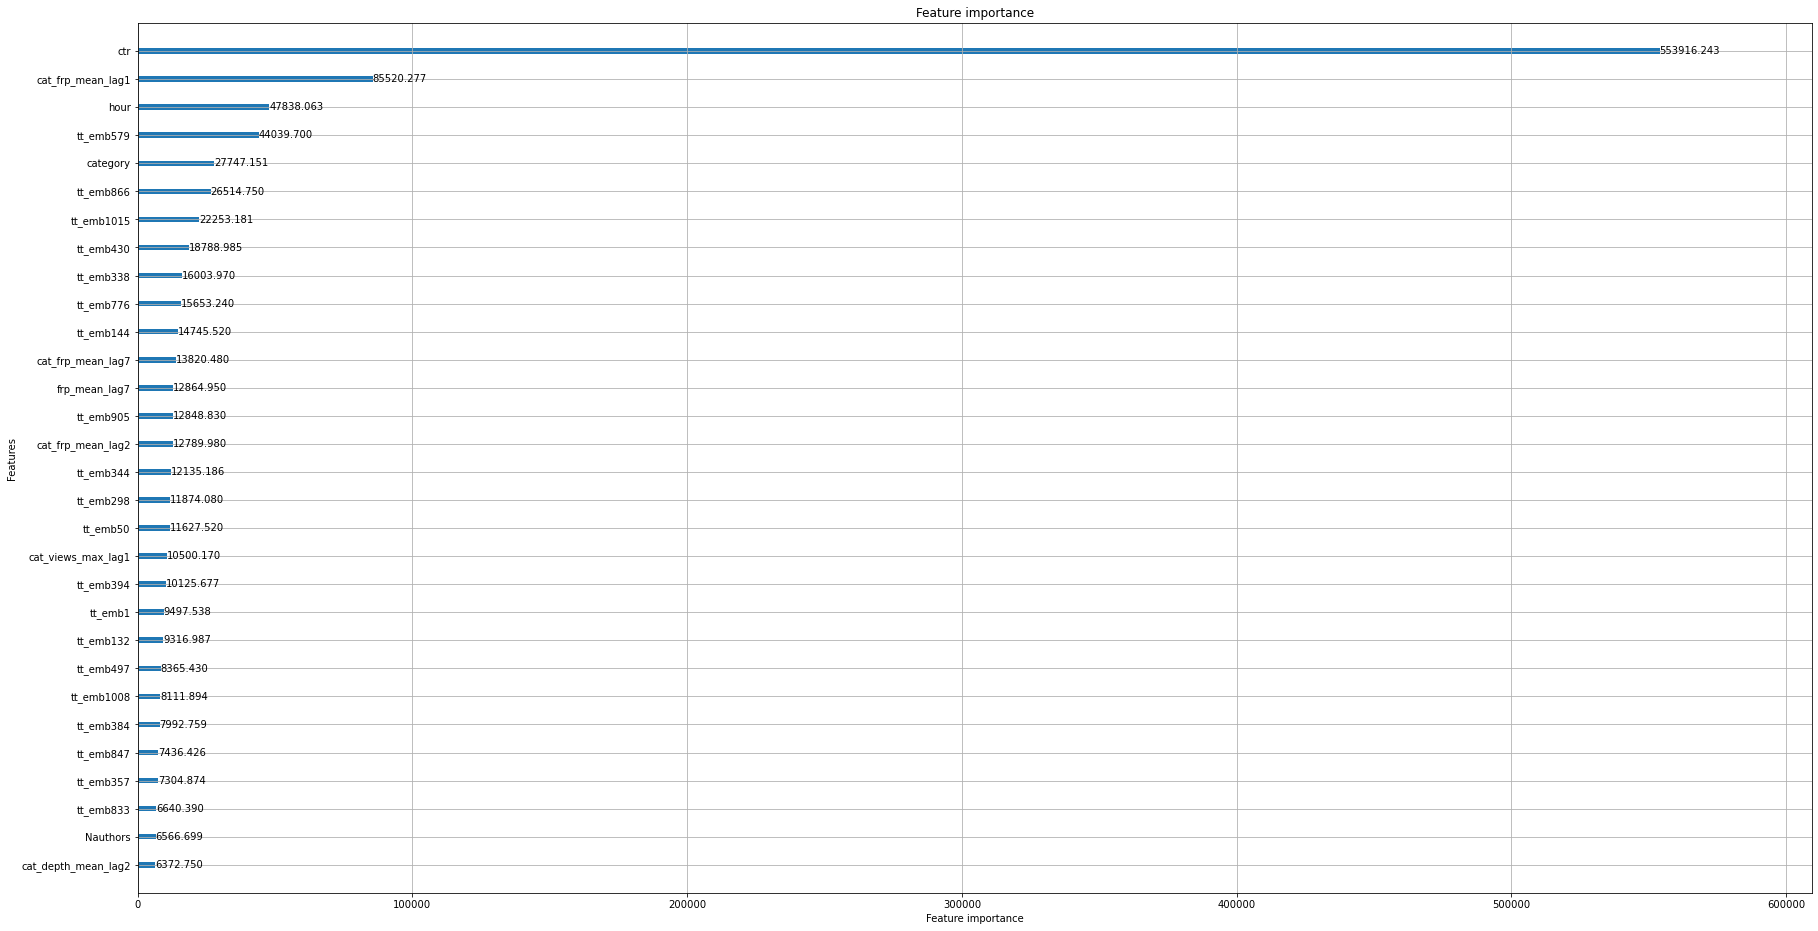

In [31]:
lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [32]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6472641643134665, 0.5074909751799647)

In [34]:
NTRY = 6

## save models

In [35]:
lgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_lgm_views.txt'), num_iteration = lgb_model_views.best_iteration)
lgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NTRY}_lgm_depth.txt'), num_iteration = lgb_model_depth.best_iteration)
lgb_model_frp.save_model(  os.path.join(DIR_MODELS, f'{NTRY}_lgm_frp.txt'),   num_iteration = lgb_model_frp.best_iteration)

## make predict

In [36]:
pred_views = lgb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = lgb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = lgb_model_frp.predict(  df_test[cat_cols + num_cols])

In [37]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [38]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,18770.129463,1.173871,40.491870
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,13384.191240,1.056498,32.886544
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,13384.191240,1.060460,29.196532
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,13384.191240,1.074826,38.086143
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,405810.135829,1.182824,32.451388


In [39]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_ttl_emb_depth_frp.csv'), index = False)